In [ ]:
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import rioxarray as rxr
import pandas as pd
from earhlab_lib import hyper_plsr

In [82]:

# Read the csv (training) data and the hyperspectral image
csv_data = pd.read_csv("./data/raw/Data.csv")
hyper_img = rxr.open_rasterio("./data/raw/hyper_image.tif")
# Make the band number to start with 0 to make it coonsistent with python indexing
hyper_img["band"] = hyper_img["band"] - 1

In [ ]:
# Raw data exploration
print((f"\nNumber of observations:{csv_data.shape[0]-1}"
f" and {csv_data.shape[1]-1} spectral bands.\n"))
print(csv_data)

In [ ]:
# The hyperspectral data are in tif format and is called as an xarray object
print(hyper_img)

In [ ]:
# plot the false color composite of the image: 

plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
hyper_img.isel(band=114).plot(ax=ax, add_colorbar=False)
ax.set_title("Shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


## Cleaning the training data:
1. Remove observations with nan values (no nitrogen measured).
2. Remove the columns with negative reflectance.
3. Remove water absorption bands.    

In [ ]:
X, y, non_negative_columns, water_bands, wl = hyper_plsr.clean_data(csv_data)


In [ ]:
# plot the spectr in the training set:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
plt.plot(wl,X.T,color="gray")
ax.set_title("Hyperspectral signature of training plots")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflectance")
plt.show()


## Train the plsr model usign two different band selections techniques
* The first technique is called VIP
* The second technique is just removing band with the lowest coefficients

In [ ]:
# Fit the vpn plsr model
ml1 = hyper_plsr()
ml1.plsr_vip(X, y, max_comp=15)

# Fit the variable selection method (It may take a few minutes)
ml2 = hyper_plsr()
ml2.plsr_vs(X, y, 15)


## Lets take a look at the scores of fitted models using both approach

In [ ]:
print(
    (
        f"VIP model calibration r2 and rmse:{np.round(ml1.scores[0],2)},"
        f" {np.round(ml1.scores[2],2)}."
        f"\nVIP model cross calibration r2 and rmse:{np.round(ml1.scores[1],2)},"
        f" {np.round(ml1.scores[3],2)}.\n"
        f"VS model calibration r2 and rmse:{np.round(ml2.scores[0],2)},"
        f" {np.round(ml2.scores[2],2)}."
        f"\nVS model cross calibration r2 and rmse:{np.round(ml2.scores[1],2)},"
        f" {np.round(ml2.scores[3],2)}.\n"
    )
)

In [58]:
wl[ml2.sorted_ind[ml2.wav:]]

array([1653.5625  , 2339.750244, 2019.195435, 1638.536499, 1748.727173,
       1042.504761, 2424.897705, 2314.706787, 2469.975586, 1458.224365,
       2014.186768, 1287.929565, 1177.73877 , 1483.2677  , 1262.88623 ,
       1478.259033,  767.027832, 2419.888916, 2004.169312, 2129.38623 ,
       2009.177979, 2439.923584, 2505.036377, 2500.027588, 2479.99292 ,
       2485.001709])

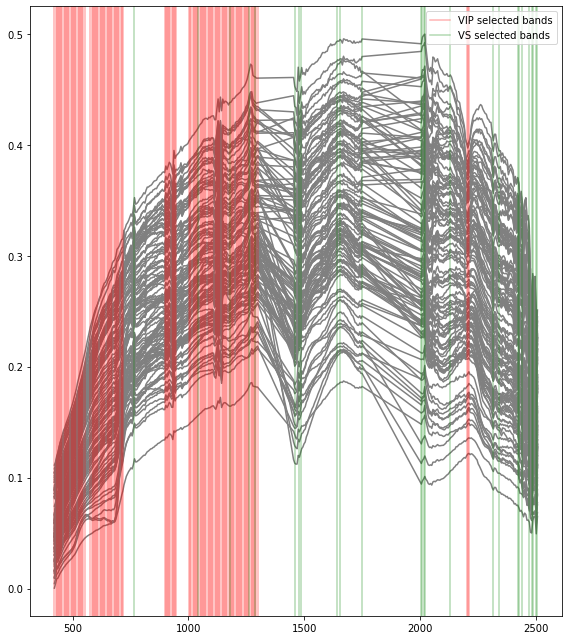

In [73]:
#Ploting the selected bands
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
selected_wl_vip = wl[ml1.selected_index]

[
    plt.axvline(x=selected_wl[i], color="red", alpha=0.3, label="VIP selected bands")
    for i in range(len(selected_wl_vip))
]

selected_wl_vs = wl[ml2.sorted_ind[ml2.wav :]]
[
    plt.axvline(
        x=selected_wl_vs[i], color="green", alpha=0.3, label="VS selected bands"
    )
    for i in range(len(selected_wl_vs))
]
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k:v for k,v in zip(labels, handles)}
plt.legend(temp.values(), temp.keys(), loc='best')
plt.tight_layout()
plt.show()


As you can see compare to VIP band selection, the simple variable selection (VS model) led to better calibratio and validation results. 

In [83]:
# Apply VS model to the image 

hyper_img = hyper_img.isel(band=non_negative_columns)
hyper_img = hyper_img.drop(water_bands, dim="band")
img_sorted = hyper_img[ml2.sorted_ind, :, :]
img_selected = img_sorted[ml2.wav :, :, :]
print(img_selected)

<xarray.DataArray (band: 26, y: 559, x: 572)>
[8313448 values with dtype=float32]
Coordinates:
  * band         (band) int64 237 339 275 234 271 132 ... 359 372 371 367 368
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


In [84]:
nitrogen_map = hyper_plsr.xr_predict(img_selected, ml2.model, "band")

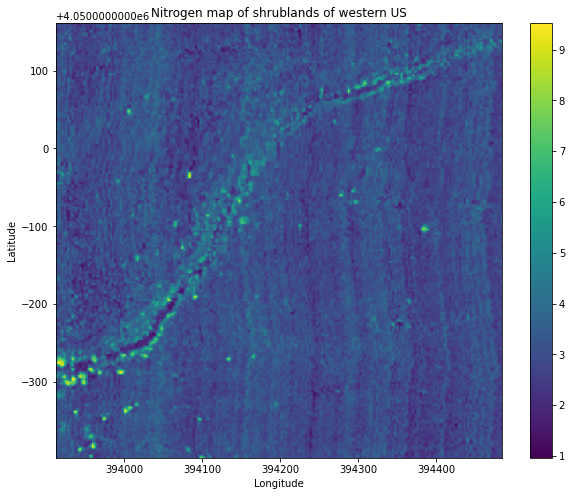

In [86]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
nitrogen_map.plot()
ax.set_title("Nitrogen map of shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()